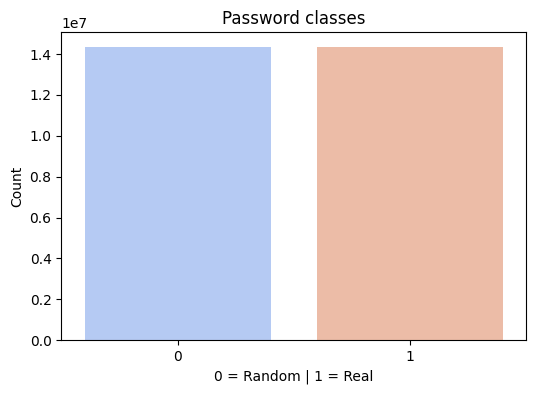

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("password_dataset.csv")
df = df.dropna(subset=["password"])

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="is_meaningful", hue="is_meaningful", palette="coolwarm", legend=False)
plt.title("Password classes")
plt.xlabel("0 = Random | 1 = Real")
plt.ylabel("Count")
plt.show()


In [3]:
df["password"].isnull().sum()


np.int64(0)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

passwords = df["password"].astype(str).tolist()
y = df["is_meaningful"].values

unique_chars = sorted(set("".join(passwords)))
char_to_idx = {char: i + 1 for i, char in enumerate(unique_chars)}

max_len = max(len(p) for p in passwords)

def encode_password(password):
    encoded = [char_to_idx.get(char, 0) for char in password]
    padded = encoded + [0] * (max_len - len(encoded))
    return torch.tensor(padded[:max_len], dtype=torch.long)

class PasswordDataset(Dataset):
    def __init__(self, passwords, labels):
        self.passwords = passwords
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.passwords)

    def __getitem__(self, idx):
        encoded_pw = encode_password(self.passwords[idx])
        return encoded_pw, self.labels[idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = PasswordDataset(passwords, y)
train_size = int(0.98 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim


class DeepGRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(DeepGRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)  
        self.gru = nn.GRU(embedding_dim, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
        self.fc1 = nn.Linear(128 * 2, 64) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  

        
    def forward(self, x):
        x = self.embedding(x)  
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x) 
        return x  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 128
vocab_size = len(unique_chars) + 1  

model = DeepGRUModel(vocab_size, embedding_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(vocab_size)

195


In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.amp.GradScaler("cuda")

def train(model, train_loader, criterion, optimizer, device, accumulation_steps=4):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    optimizer.zero_grad()
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, dtype=torch.float32, non_blocking=True)
        
        with torch.amp.autocast("cuda"):
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets) / accumulation_steps
        
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        predicted = (outputs >= 0.5).float()
        correct += (predicted == targets).sum().detach().cpu().numpy()
        total += targets.size(0)

        if batch_idx % 1000 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item() * accumulation_steps:.4f}, Accuracy: {correct / total:.4f}")

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total if total > 0 else 0
    print(f"Epoch Finished - Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


In [7]:
train(model, train_loader, criterion, optimizer, device)


Batch 0/109820 - Loss: 0.6935, Accuracy: 0.4883
Batch 1000/109820 - Loss: 0.0162, Accuracy: 0.9317
Batch 2000/109820 - Loss: 0.0202, Accuracy: 0.9616
Batch 3000/109820 - Loss: 0.0066, Accuracy: 0.9720
Batch 4000/109820 - Loss: 0.0140, Accuracy: 0.9774
Batch 5000/109820 - Loss: 0.0192, Accuracy: 0.9806
Batch 6000/109820 - Loss: 0.0041, Accuracy: 0.9829
Batch 7000/109820 - Loss: 0.0247, Accuracy: 0.9846
Batch 8000/109820 - Loss: 0.0110, Accuracy: 0.9858
Batch 9000/109820 - Loss: 0.0477, Accuracy: 0.9868
Batch 10000/109820 - Loss: 0.0133, Accuracy: 0.9876
Batch 11000/109820 - Loss: 0.0305, Accuracy: 0.9883
Batch 12000/109820 - Loss: 0.0033, Accuracy: 0.9889
Batch 13000/109820 - Loss: 0.0038, Accuracy: 0.9894
Batch 14000/109820 - Loss: 0.0108, Accuracy: 0.9898
Batch 15000/109820 - Loss: 0.0360, Accuracy: 0.9902
Batch 16000/109820 - Loss: 0.0220, Accuracy: 0.9905
Batch 17000/109820 - Loss: 0.0032, Accuracy: 0.9908
Batch 18000/109820 - Loss: 0.0041, Accuracy: 0.9910
Batch 19000/109820 - Loss

In [8]:
import torch
import numpy as np
from tqdm import tqdm 
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def evaluate(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating", unit="batch"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            with torch.amp.autocast("cuda"):
                outputs = model(inputs).squeeze()
                probs = torch.sigmoid(outputs)

            y_scores.extend(probs.cpu().numpy())
            preds = (probs >= 0.5).cpu().numpy()

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred), np.array(y_scores)


y_true, y_pred, y_scores = evaluate(model, test_loader, device)



Evaluating: 100%|██████████| 2242/2242 [01:06<00:00, 33.68batch/s]


Classification Report:
              precision    recall  f1-score   support

         0.0     0.9963    0.9966    0.9965    286864
         1.0     0.9966    0.9963    0.9965    286886

    accuracy                         0.9965    573750
   macro avg     0.9965    0.9965    0.9965    573750
weighted avg     0.9965    0.9965    0.9965    573750

Cohen's Kappa Score: 0.9929


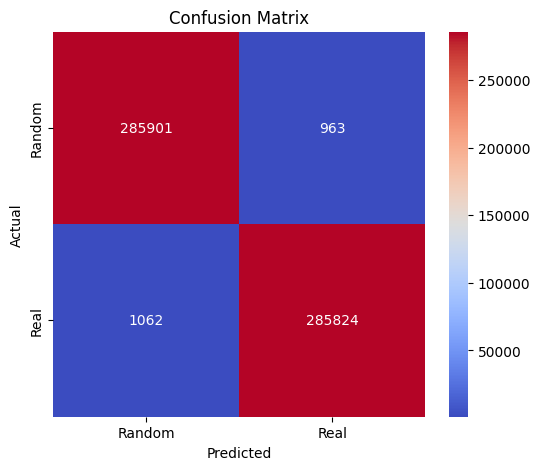

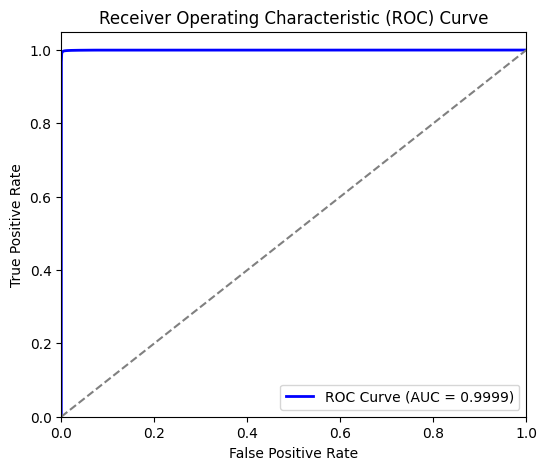

In [9]:
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Random", "Real"], yticklabels=["Random", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [10]:
import torch

torch.save(model.state_dict(), "model.pth")
